In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

In [3]:
dit_df = pd.read_csv('dit_model_predictions.csv')

<Axes: >

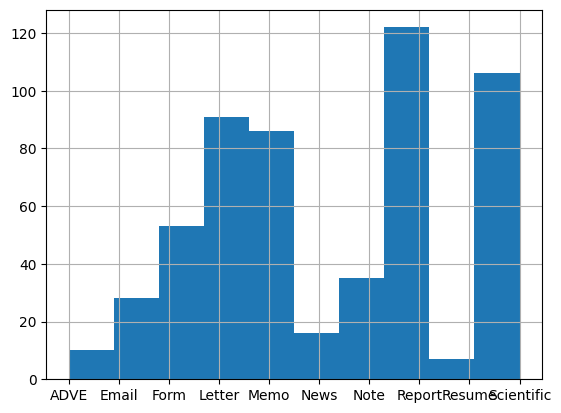

In [4]:
dit_mistakes_df = dit_df[dit_df['Tobacco Label'] != dit_df['Predicted Label']]
dit_mistakes_df['Tobacco Label'].hist()

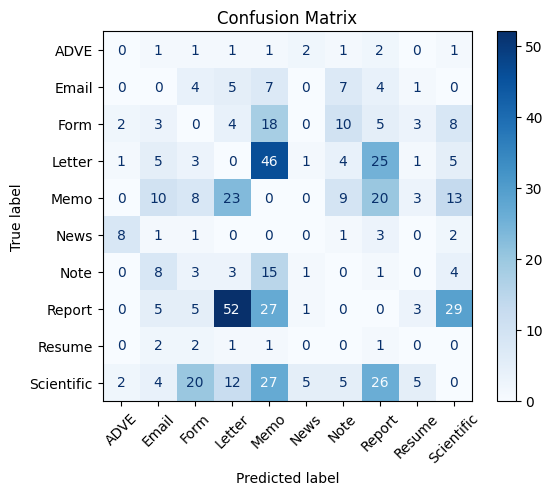

In [5]:
# Compute the confusion matrix
cm = confusion_matrix(dit_mistakes_df['Tobacco Label'], dit_mistakes_df['Predicted Label'])

# Get the Tobacco3482 labels
labels = sorted(dit_mistakes_df['Tobacco Label'].unique())

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

In [6]:
labels_df = pd.read_csv('tobacco3482_multi_labels.csv')

In [7]:
labels_df.loc[labels_df['Filename'] == '2025040448.jpg', 'New Labels'] = "['Memo']"

In [8]:
import ast

# Convert string representations of lists to actual lists
def convert_to_list(val):
    if isinstance(val, str):
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            return val
    return val

# Apply the function to convert 'New Labels' column to lists
labels_df['New Labels'] = labels_df['New Labels'].apply(convert_to_list)

In [9]:
# Finding mislabeled documents
mislabeled_docs = labels_df[(labels_df['New Labels'].apply(len) > 0) & (~labels_df.apply(lambda x: x['Tobacco Label'] in x['New Labels'], axis=1))]

# Finding unknown labels (New Labels list is empty)
unknown_labels_docs = labels_df[labels_df['New Labels'].apply(len) == 0]

# Printing counts
print("Mislabeled documents count:", len(mislabeled_docs))
print("Unknown labels documents count:", len(unknown_labels_docs))

Mislabeled documents count: 258
Unknown labels documents count: 151


In [10]:
mislabeled_docs

,Unnamed: 0,Filename,New Labels,Tobacco Label
0,0,0000008957.jpg,[Report],Memo
50,50,0000628923.jpg,[Memo],Note
160,160,10080510.jpg,[Report],Note
220,220,12304582.jpg,[Resume],Report
229,229,1368724.jpg,"[Report, Scientific]",Memo
...,...,...,...,...
2629,2629,523186064+-6066.jpg,[Memo],Letter
2721,2721,528008233+-8233.jpg,"[Memo, Report]",Email
2726,2726,528023553+-3553.jpg,[Memo],Email
2928,2928,2078315311.jpg,[Note],Email


Prepare data to create [UpSet plot](https://en.wikipedia.org/wiki/UpSet_plot#:~:text=UpSet%20plots%20are%20a%20data,sets%20(or%20vice%20versa).) to analyse multi-label images.

In [11]:
labels_df_upset = labels_df[labels_df['New Labels'].apply(lambda x: len(x) > 1)]
print("Multi-label documents count:", len(labels_df_upset))
labels_df_exploded = labels_df_upset.explode('New Labels')
unique_tobacco_labels = labels_df['Tobacco Label'].unique()

dfs = {}

for label in unique_tobacco_labels:
    # Filter rows where New Labels match the Tobacco Label
    filtered_df = labels_df_exploded[labels_df_exploded['New Labels'] == label]
    # Create a DataFrame with boolean column indicating the presence of the label
    dfs[label] = pd.DataFrame({label: True, 'Filename': filtered_df['Filename']})

# Merge all DataFrames together on 'Filename'
upset_df = pd.DataFrame({'Filename': labels_df_upset['Filename']}).drop_duplicates()
for df in dfs.values():
    upset_df = upset_df.merge(df, on='Filename', how='outer')

upset_df = upset_df.fillna(False)
upset_df = upset_df.set_index(list(unique_tobacco_labels))
upset_df.head()

Multi-label documents count: 583


Filename
Memo Letter Resume Note  Report Scientific News  Form  ADVE  Email                
True False  False  False True   False      False False False False  0000073229.jpg
                                                             False  0000083559.jpg
                                                             False  0000108319.jpg
                                                             False  0000141695.jpg
                                                             False  0000159555.jpg

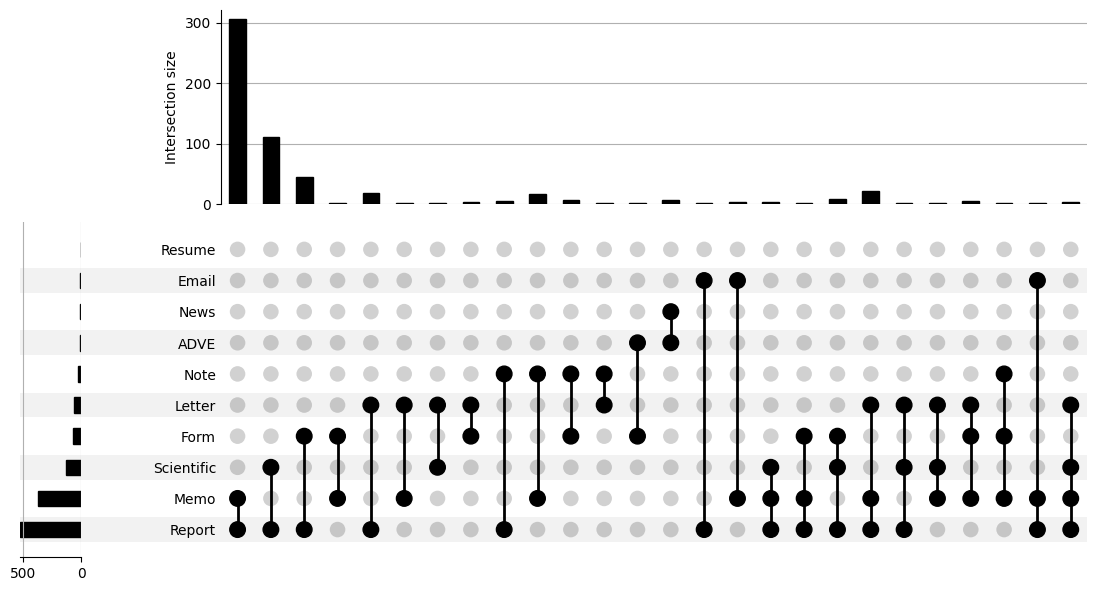

In [12]:
from upsetplot import UpSet, plot
import matplotlib.pyplot as plt

plot(upset_df)

# Save the UpSet plot to a PDF file
plt.savefig('upset_plot.pdf', dpi=300)

In [13]:
# Merge DataFrames on 'Filename' column
merged_df = pd.merge(dit_mistakes_df, labels_df, on='Filename')

In [14]:
# Model asked to predict Tobacco3482 label for image with unknown labels
def is_unknown(row):
    return row['New Labels'] == []

# Model predicted valid alternative label from Tobacco3482 label
def is_valid_label(row):
    return row['Predicted Label'] in row['New Labels']

unknown_df = merged_df[merged_df.apply(is_unknown, axis=1)]

valid_label_df = merged_df[merged_df.apply(is_valid_label, axis=1)]

unknown_count = unknown_df.shape[0]
valid_label_count = valid_label_df.shape[0]

print("In DIT Mistakes:")
print(f"Number of unknown label mistakes: {unknown_count}")
print(f"Number of valid label mistakes: {valid_label_count}")

In DIT Mistakes:
Number of unknown label mistakes: 49
Number of valid label mistakes: 147


## Acknowledgments

This notebook includes code and content generated with the assistance of ChatGPT, an AI language model developed by OpenAI.